In [46]:
import os
import math
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr 

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from scipy.stats import skew,stats
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

In [47]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
data = pd.read_csv('월별 총물동량.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

In [4]:
#data.dtypes --> float type 확인
data['평균미국달러환율'] = (data['평균미국달러환율'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
data['부산항수출금액'] = (data['부산항수출금액'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
data['부산항수입금액'] = (data['부산항수입금액'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
#data.dtypes # object로 잘못 인식한 데이터 float로 조정 

### VAR(Vector Auto Regression) 벡터자기회귀모형

In [5]:
from statsmodels.tsa.api import VAR

In [6]:
Var_data = data
Var_data_diff_ = Var_data.diff(1).dropna()

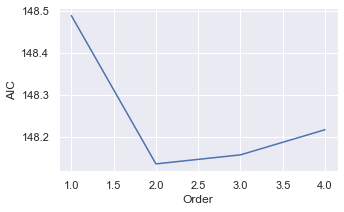

In [7]:
# VAR 차수 설정 
forecasting_model = VAR(Var_data_diff_) #모델명 설정 
results_aic = []
for p in range(1,5): # 차수 1~ 10 설정 
    results = forecasting_model.fit(p)
    results_aic.append(results.aic)
    
sns.set()
plt.figure(figsize=(5,3))
plt.plot(list(np.arange(1,5,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show() # VAR차수 p -- > p = 2로 설정 

### 그레인저 인과관계 
     - H0 : 인과관계 X
     - H1 : 인과관계 O

In [8]:
import statsmodels.tsa.stattools as st

#### BDI --> TEU

In [62]:
raw = data[['TEU','BDI']]

In [63]:
target = raw.TEU.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y1_integ_order = 0
if integ_result[1] > 0.1:
    Y1_integ_order = Y1_integ_order + 1
    
target = raw.BDI.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y2_integ_order = 0
if integ_result[1] > 0.1:
    Y2_integ_order = Y2_integ_order + 1
print('Y1_order: ', Y1_integ_order, 'Y2_order: ', Y2_integ_order)

Y1_order:  1 Y2_order:  1


In [64]:
# Granger Causality 테스트
print('\n[BDI -> TEU]') 
granger_result1 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().values, maxlag=12, verbose=True)
print('\n[TEU -> BDI]') 
granger_result2 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().iloc[:,[1,0]].values, maxlag=12, verbose=True)


[BDI -> TEU]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.1704 , p=0.0010  , df_denom=262, df_num=1
ssr based chi2 test:   chi2=11.2983 , p=0.0008  , df=1
likelihood ratio test: chi2=11.0641 , p=0.0009  , df=1
parameter F test:         F=11.1704 , p=0.0010  , df_denom=262, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3280  , p=0.0054  , df_denom=259, df_num=2
ssr based chi2 test:   chi2=10.8618 , p=0.0044  , df=2
likelihood ratio test: chi2=10.6443 , p=0.0049  , df=2
parameter F test:         F=5.3280  , p=0.0054  , df_denom=259, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5282  , p=0.0155  , df_denom=256, df_num=3
ssr based chi2 test:   chi2=10.8739 , p=0.0124  , df=3
likelihood ratio test: chi2=10.6551 , p=0.0137  , df=3
parameter F test:         F=3.5282  , p=0.0155  , df_denom=256, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.3173

#### 무역수지 --> TEU

In [66]:
raw = data[['TEU','무역수지']]

target = raw.TEU.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y1_integ_order = 0
if integ_result[1] > 0.1:
    Y1_integ_order = Y1_integ_order + 1
    
target = raw.무역수지.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y2_integ_order = 0
if integ_result[1] > 0.1:
    Y2_integ_order = Y2_integ_order + 1
print('Y1_order: ', Y1_integ_order, 'Y2_order: ', Y2_integ_order)

Y1_order:  1 Y2_order:  1


In [67]:
# Granger Causality 테스트
print('\n[무역수지 -> TEU]') 
granger_result1 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().values, maxlag=12, verbose=True)
print('\n[TEU -> 무역수지]') 
granger_result2 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().iloc[:,[1,0]].values, maxlag=12, verbose=True)


[무역수지 -> TEU]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=46.7154 , p=0.0000  , df_denom=262, df_num=1
ssr based chi2 test:   chi2=47.2503 , p=0.0000  , df=1
likelihood ratio test: chi2=43.4799 , p=0.0000  , df=1
parameter F test:         F=46.7154 , p=0.0000  , df_denom=262, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=22.7563 , p=0.0000  , df_denom=259, df_num=2
ssr based chi2 test:   chi2=46.3913 , p=0.0000  , df=2
likelihood ratio test: chi2=42.7376 , p=0.0000  , df=2
parameter F test:         F=22.7563 , p=0.0000  , df_denom=259, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=15.6325 , p=0.0000  , df_denom=256, df_num=3
ssr based chi2 test:   chi2=48.1798 , p=0.0000  , df=3
likelihood ratio test: chi2=44.2411 , p=0.0000  , df=3
parameter F test:         F=15.6325 , p=0.0000  , df_denom=256, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=13.14

#### 평균국제유가 --> TEU

In [68]:
raw = data[['TEU','평균국제유가']]

target = raw.TEU.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y1_integ_order = 0
if integ_result[1] > 0.1:
    Y1_integ_order = Y1_integ_order + 1
    
target = raw.평균국제유가.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y2_integ_order = 0
if integ_result[1] > 0.1:
    Y2_integ_order = Y2_integ_order + 1
print('Y1_order: ', Y1_integ_order, 'Y2_order: ', Y2_integ_order)

Y1_order:  1 Y2_order:  1


In [69]:
# Granger Causality 테스트
print('\n[평균국제유가 -> TEU]') 
granger_result1 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().values, maxlag=12, verbose=True)
print('\n[TEU -> 평균국제유가]') 
granger_result2 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().iloc[:,[1,0]].values, maxlag=12, verbose=True)


[평균국제유가 -> TEU]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1033  , p=0.0247  , df_denom=262, df_num=1
ssr based chi2 test:   chi2=5.1617  , p=0.0231  , df=1
likelihood ratio test: chi2=5.1121  , p=0.0238  , df=1
parameter F test:         F=5.1033  , p=0.0247  , df_denom=262, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.3828  , p=0.0020  , df_denom=259, df_num=2
ssr based chi2 test:   chi2=13.0121 , p=0.0015  , df=2
likelihood ratio test: chi2=12.7015 , p=0.0017  , df=2
parameter F test:         F=6.3828  , p=0.0020  , df_denom=259, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.2214  , p=0.0004  , df_denom=256, df_num=3
ssr based chi2 test:   chi2=19.1744 , p=0.0003  , df=3
likelihood ratio test: chi2=18.5077 , p=0.0003  , df=3
parameter F test:         F=6.2214  , p=0.0004  , df_denom=256, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.2

#### 평균미국달러환율--> TEU

In [70]:
raw = data[['TEU','평균미국달러환율']]

target = raw.TEU.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y1_integ_order = 0
if integ_result[1] > 0.1:
    Y1_integ_order = Y1_integ_order + 1
    
target = raw.평균미국달러환율.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y2_integ_order = 0
if integ_result[1] > 0.1:
    Y2_integ_order = Y2_integ_order + 1
print('Y1_order: ', Y1_integ_order, 'Y2_order: ', Y2_integ_order)

Y1_order:  1 Y2_order:  0


In [71]:
# Granger Causality 테스트
print('\n[평균미국달러환율-> TEU]') 
granger_result1 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().values, maxlag=12, verbose=True)
print('\n[TEU -> 평균미국달러환율]') 
granger_result2 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().iloc[:,[1,0]].values, maxlag=12, verbose=True)


[평균미국달러환율-> TEU]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0654  , p=0.7984  , df_denom=262, df_num=1
ssr based chi2 test:   chi2=0.0661  , p=0.7971  , df=1
likelihood ratio test: chi2=0.0661  , p=0.7971  , df=1
parameter F test:         F=0.0654  , p=0.7984  , df_denom=262, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1398  , p=0.3215  , df_denom=259, df_num=2
ssr based chi2 test:   chi2=2.3236  , p=0.3129  , df=2
likelihood ratio test: chi2=2.3134  , p=0.3145  , df=2
parameter F test:         F=1.1398  , p=0.3215  , df_denom=259, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9084  , p=0.1286  , df_denom=256, df_num=3
ssr based chi2 test:   chi2=5.8818  , p=0.1175  , df=3
likelihood ratio test: chi2=5.8170  , p=0.1209  , df=3
parameter F test:         F=1.9084  , p=0.1286  , df_denom=256, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.

#### 운송수지--> TEU

In [72]:
raw = data[['TEU','운송수지']]

target = raw.TEU.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y1_integ_order = 0
if integ_result[1] > 0.1:
    Y1_integ_order = Y1_integ_order + 1
    
target = raw.운송수지.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y2_integ_order = 0
if integ_result[1] > 0.1:
    Y2_integ_order = Y2_integ_order + 1
print('Y1_order: ', Y1_integ_order, 'Y2_order: ', Y2_integ_order)

Y1_order:  1 Y2_order:  1


In [73]:
# Granger Causality 테스트
print('\n[운송수지-> TEU]') 
granger_result1 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().values, maxlag=12, verbose=True)
print('\n[TEU -> 운송수지]') 
granger_result2 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().iloc[:,[1,0]].values, maxlag=12, verbose=True)


[운송수지-> TEU]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1648  , p=0.2815  , df_denom=262, df_num=1
ssr based chi2 test:   chi2=1.1781  , p=0.2777  , df=1
likelihood ratio test: chi2=1.1755  , p=0.2783  , df=1
parameter F test:         F=1.1648  , p=0.2815  , df_denom=262, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4173  , p=0.2442  , df_denom=259, df_num=2
ssr based chi2 test:   chi2=2.8893  , p=0.2358  , df=2
likelihood ratio test: chi2=2.8736  , p=0.2377  , df=2
parameter F test:         F=1.4173  , p=0.2442  , df_denom=259, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9883  , p=0.3989  , df_denom=256, df_num=3
ssr based chi2 test:   chi2=3.0458  , p=0.3846  , df=3
likelihood ratio test: chi2=3.0283  , p=0.3873  , df=3
parameter F test:         F=0.9883  , p=0.3989  , df_denom=256, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7984

#### 경상수지--> TEU

In [74]:
raw = data[['TEU','경상수지']]

target = raw.TEU.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y1_integ_order = 0
if integ_result[1] > 0.1:
    Y1_integ_order = Y1_integ_order + 1
    
target = raw.경상수지.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y2_integ_order = 0
if integ_result[1] > 0.1:
    Y2_integ_order = Y2_integ_order + 1
print('Y1_order: ', Y1_integ_order, 'Y2_order: ', Y2_integ_order)

Y1_order:  1 Y2_order:  1


In [75]:
# Granger Causality 테스트
print('\n[경상수지-> TEU]') 
granger_result1 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().values, maxlag=12, verbose=True)
print('\n[TEU -> 경상수지]') 
granger_result2 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().iloc[:,[1,0]].values, maxlag=12, verbose=True)


[경상수지-> TEU]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.3735 , p=0.0000  , df_denom=262, df_num=1
ssr based chi2 test:   chi2=17.5724 , p=0.0000  , df=1
likelihood ratio test: chi2=17.0143 , p=0.0000  , df=1
parameter F test:         F=17.3735 , p=0.0000  , df_denom=262, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3581  , p=0.0052  , df_denom=259, df_num=2
ssr based chi2 test:   chi2=10.9231 , p=0.0042  , df=2
likelihood ratio test: chi2=10.7032 , p=0.0047  , df=2
parameter F test:         F=5.3581  , p=0.0052  , df_denom=259, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=10.0715 , p=0.0000  , df_denom=256, df_num=3
ssr based chi2 test:   chi2=31.0407 , p=0.0000  , df=3
likelihood ratio test: chi2=29.3413 , p=0.0000  , df=3
parameter F test:         F=10.0715 , p=0.0000  , df_denom=256, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=13.421

#### 경기종합지수--> TEU

In [76]:
raw = data[['TEU','경기종합지수']]

target = raw.TEU.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y1_integ_order = 0
if integ_result[1] > 0.1:
    Y1_integ_order = Y1_integ_order + 1
    
target = raw.경기종합지수.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y2_integ_order = 0
if integ_result[1] > 0.1:
    Y2_integ_order = Y2_integ_order + 1
print('Y1_order: ', Y1_integ_order, 'Y2_order: ', Y2_integ_order)

Y1_order:  1 Y2_order:  1


In [77]:
# Granger Causality 테스트
print('\n[경기종합지수-> TEU]') 
granger_result1 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().values, maxlag=12, verbose=True)
print('\n[TEU -> 경기종합지수]') 
granger_result2 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().iloc[:,[1,0]].values, maxlag=12, verbose=True)


[경기종합지수-> TEU]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0883  , p=0.2978  , df_denom=262, df_num=1
ssr based chi2 test:   chi2=1.1008  , p=0.2941  , df=1
likelihood ratio test: chi2=1.0985  , p=0.2946  , df=1
parameter F test:         F=1.0883  , p=0.2978  , df_denom=262, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8535  , p=0.4271  , df_denom=259, df_num=2
ssr based chi2 test:   chi2=1.7400  , p=0.4190  , df=2
likelihood ratio test: chi2=1.7343  , p=0.4202  , df=2
parameter F test:         F=0.8535  , p=0.4271  , df_denom=259, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6527  , p=0.5819  , df_denom=256, df_num=3
ssr based chi2 test:   chi2=2.0116  , p=0.5700  , df=3
likelihood ratio test: chi2=2.0039  , p=0.5716  , df=3
parameter F test:         F=0.6527  , p=0.5819  , df_denom=256, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.94

#### 수출물가지수 --> TEU

In [78]:
raw = data[['TEU','수출물가지수']]

target = raw.TEU.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y1_integ_order = 0
if integ_result[1] > 0.1:
    Y1_integ_order = Y1_integ_order + 1
    
target = raw.수출물가지수.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y2_integ_order = 0
if integ_result[1] > 0.1:
    Y2_integ_order = Y2_integ_order + 1
print('Y1_order: ', Y1_integ_order, 'Y2_order: ', Y2_integ_order)

Y1_order:  1 Y2_order:  0


In [79]:
# Granger Causality 테스트
print('\n[수출물가지수-> TEU]') 
granger_result1 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().values, maxlag=12, verbose=True)
print('\n[TEU -> 수출물가지수]') 
granger_result2 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().iloc[:,[1,0]].values, maxlag=12, verbose=True)


[수출물가지수-> TEU]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8919  , p=0.1702  , df_denom=262, df_num=1
ssr based chi2 test:   chi2=1.9136  , p=0.1666  , df=1
likelihood ratio test: chi2=1.9067  , p=0.1673  , df=1
parameter F test:         F=1.8919  , p=0.1702  , df_denom=262, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1948  , p=0.3044  , df_denom=259, df_num=2
ssr based chi2 test:   chi2=2.4358  , p=0.2958  , df=2
likelihood ratio test: chi2=2.4246  , p=0.2975  , df=2
parameter F test:         F=1.1948  , p=0.3044  , df_denom=259, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6845  , p=0.5622  , df_denom=256, df_num=3
ssr based chi2 test:   chi2=2.1097  , p=0.5500  , df=3
likelihood ratio test: chi2=2.1013  , p=0.5517  , df=3
parameter F test:         F=0.6845  , p=0.5622  , df_denom=256, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.48

#### 수입물가지수 --> TEU

In [80]:
raw = data[['TEU','수입물가지수']]

target = raw.TEU.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y1_integ_order = 0
if integ_result[1] > 0.1:
    Y1_integ_order = Y1_integ_order + 1
    
target = raw.수입물가지수.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y2_integ_order = 0
if integ_result[1] > 0.1:
    Y2_integ_order = Y2_integ_order + 1
print('Y1_order: ', Y1_integ_order, 'Y2_order: ', Y2_integ_order)

Y1_order:  1 Y2_order:  1


In [81]:
# Granger Causality 테스트
print('\n[수입물가지수-> TEU]') 
granger_result1 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().values, maxlag=12, verbose=True)
print('\n[TEU -> 수입물가지수]') 
granger_result2 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().iloc[:,[1,0]].values, maxlag=12, verbose=True)


[수입물가지수-> TEU]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8332  , p=0.0513  , df_denom=262, df_num=1
ssr based chi2 test:   chi2=3.8771  , p=0.0489  , df=1
likelihood ratio test: chi2=3.8490  , p=0.0498  , df=1
parameter F test:         F=3.8332  , p=0.0513  , df_denom=262, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2758  , p=0.0394  , df_denom=259, df_num=2
ssr based chi2 test:   chi2=6.6780  , p=0.0355  , df=2
likelihood ratio test: chi2=6.5950  , p=0.0370  , df=2
parameter F test:         F=3.2758  , p=0.0394  , df_denom=259, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6169  , p=0.0515  , df_denom=256, df_num=3
ssr based chi2 test:   chi2=8.0654  , p=0.0447  , df=3
likelihood ratio test: chi2=7.9442  , p=0.0472  , df=3
parameter F test:         F=2.6169  , p=0.0515  , df_denom=256, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.12

In [82]:
raw = data[['TEU','부산항수출금액']]

target = raw.TEU.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y1_integ_order = 0
if integ_result[1] > 0.1:
    Y1_integ_order = Y1_integ_order + 1
    
target = raw.부산항수출금액.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y2_integ_order = 0
if integ_result[1] > 0.1:
    Y2_integ_order = Y2_integ_order + 1
print('Y1_order: ', Y1_integ_order, 'Y2_order: ', Y2_integ_order)

Y1_order:  1 Y2_order:  1


In [83]:
# Granger Causality 테스트
print('\n[부산항수출금액-> TEU]') 
granger_result1 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().values, maxlag=12, verbose=True)
print('\n[TEU -> 부산항수출금액]') 
granger_result2 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().iloc[:,[1,0]].values, maxlag=12, verbose=True)


[부산항수출금액-> TEU]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=28.8225 , p=0.0000  , df_denom=262, df_num=1
ssr based chi2 test:   chi2=29.1525 , p=0.0000  , df=1
likelihood ratio test: chi2=27.6577 , p=0.0000  , df=1
parameter F test:         F=28.8225 , p=0.0000  , df_denom=262, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.6771 , p=0.0000  , df_denom=259, df_num=2
ssr based chi2 test:   chi2=25.8437 , p=0.0000  , df=2
likelihood ratio test: chi2=24.6557 , p=0.0000  , df=2
parameter F test:         F=12.6771 , p=0.0000  , df_denom=259, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=11.9972 , p=0.0000  , df_denom=256, df_num=3
ssr based chi2 test:   chi2=36.9759 , p=0.0000  , df=3
likelihood ratio test: chi2=34.5972 , p=0.0000  , df=3
parameter F test:         F=11.9972 , p=0.0000  , df_denom=256, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=8.5

In [84]:
raw = data[['TEU','부산항수입금액']]

target = raw.TEU.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y1_integ_order = 0
if integ_result[1] > 0.1:
    Y1_integ_order = Y1_integ_order + 1
    
target = raw.부산항수입금액.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y2_integ_order = 0
if integ_result[1] > 0.1:
    Y2_integ_order = Y2_integ_order + 1
print('Y1_order: ', Y1_integ_order, 'Y2_order: ', Y2_integ_order)

Y1_order:  1 Y2_order:  1


In [85]:
# Granger Causality 테스트
print('\n[부산항수입금액-> TEU]') 
granger_result1 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().values, maxlag=12, verbose=True)
print('\n[TEU -> 부산항수입금액]') 
granger_result2 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().iloc[:,[1,0]].values, maxlag=12, verbose=True)


[부산항수입금액-> TEU]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4026  , p=0.5263  , df_denom=262, df_num=1
ssr based chi2 test:   chi2=0.4072  , p=0.5234  , df=1
likelihood ratio test: chi2=0.4068  , p=0.5236  , df=1
parameter F test:         F=0.4026  , p=0.5263  , df_denom=262, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2056  , p=0.8143  , df_denom=259, df_num=2
ssr based chi2 test:   chi2=0.4191  , p=0.8110  , df=2
likelihood ratio test: chi2=0.4188  , p=0.8111  , df=2
parameter F test:         F=0.2056  , p=0.8143  , df_denom=259, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6224  , p=0.6011  , df_denom=256, df_num=3
ssr based chi2 test:   chi2=1.9184  , p=0.5895  , df=3
likelihood ratio test: chi2=1.9114  , p=0.5910  , df=3
parameter F test:         F=0.6224  , p=0.6011  , df_denom=256, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.5

### 충격반응분석

In [32]:
from statsmodels.tsa.api import VAR 

In [33]:
import warnings 
warnings.filterwarnings(action='ignore')

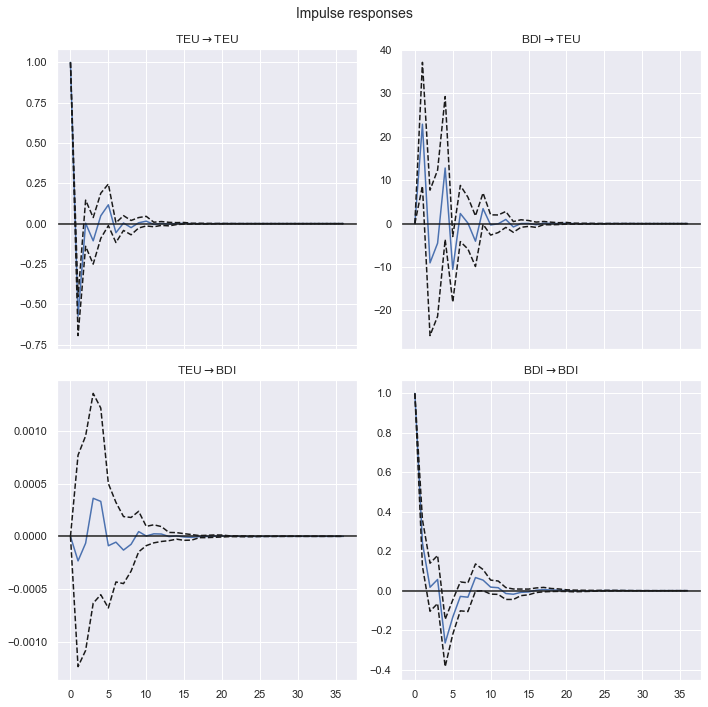

In [34]:
Var_data = data[['TEU','BDI']]
fit = sm.tsa.VAR(Var_data.diff(1).dropna()).fit(maxlags=4)

forecast_num = 36 
fit.irf(forecast_num).plot()
plt.tight_layout() 
plt.show()

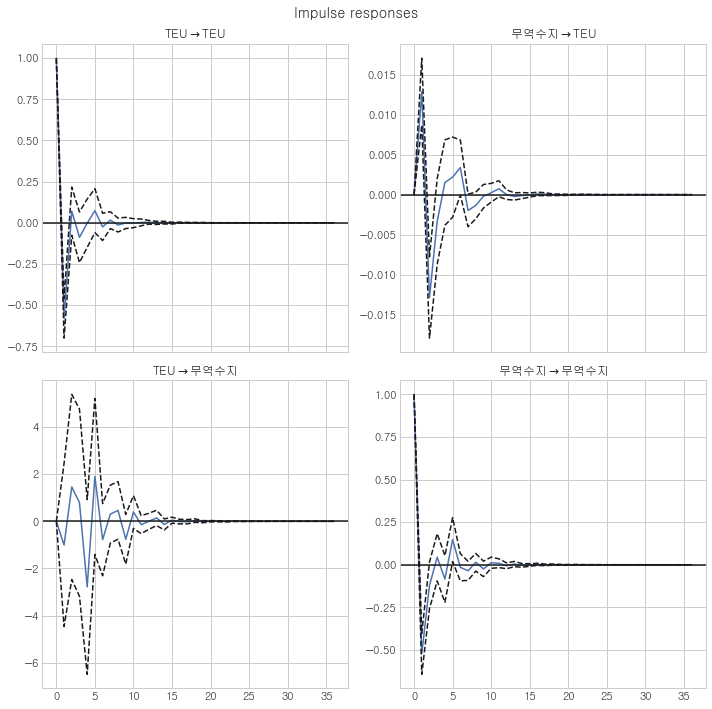

In [48]:
Var_data = data[['TEU','무역수지']]
fit = sm.tsa.VAR(Var_data.diff(1).dropna()).fit(maxlags=4)

forecast_num = 36 
fit.irf(forecast_num).plot()
plt.tight_layout() 
plt.show()

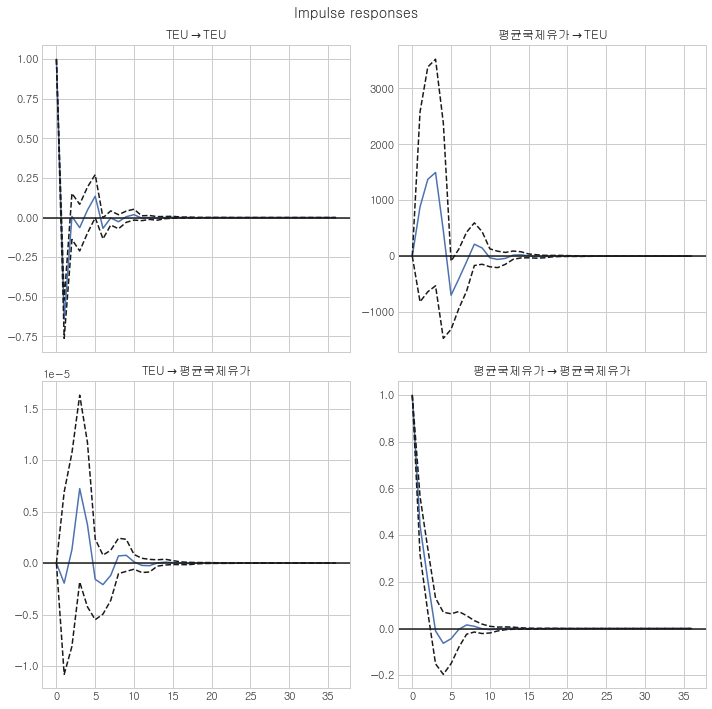

In [49]:
Var_data = data[['TEU','평균국제유가']]
fit = sm.tsa.VAR(Var_data.diff(1).dropna()).fit(maxlags=4)

forecast_num = 36 
fit.irf(forecast_num).plot()
plt.tight_layout() 
plt.show()

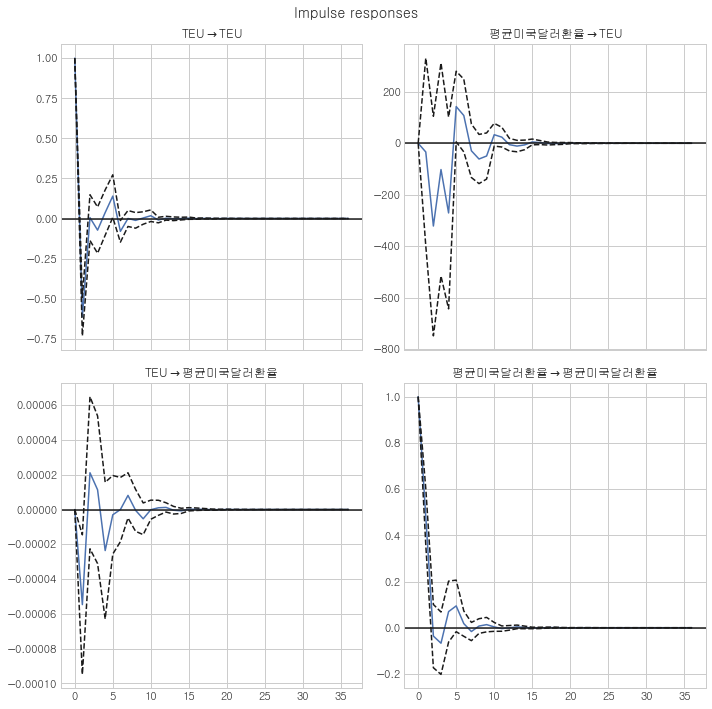

In [50]:
Var_data = data[['TEU','평균미국달러환율']]
fit = sm.tsa.VAR(Var_data.diff(1).dropna()).fit(maxlags=4)

forecast_num = 36
fit.irf(forecast_num).plot()
plt.tight_layout() 
plt.show()

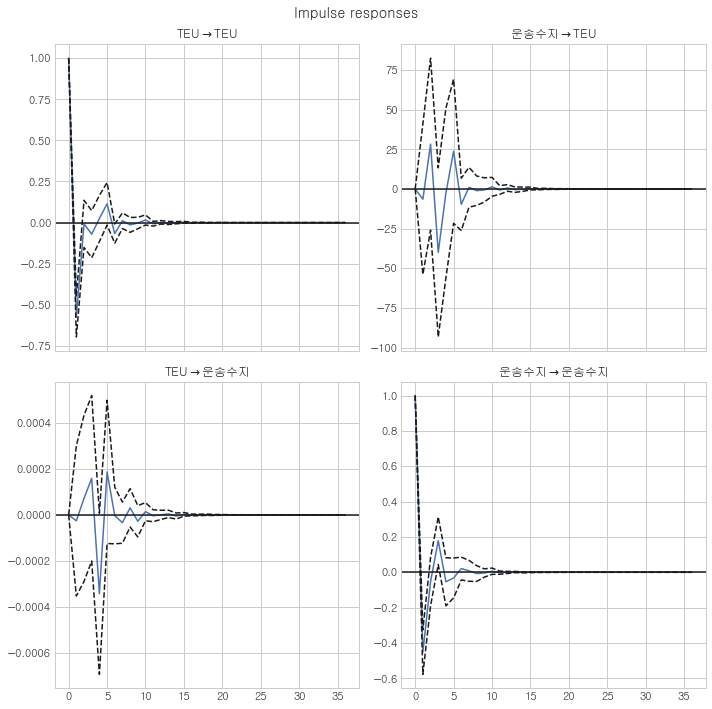

In [51]:
Var_data = data[['TEU','운송수지']]
fit = sm.tsa.VAR(Var_data.diff(1).dropna()).fit(maxlags=4)

forecast_num = 36 
fit.irf(forecast_num).plot()
plt.tight_layout() 
plt.show()

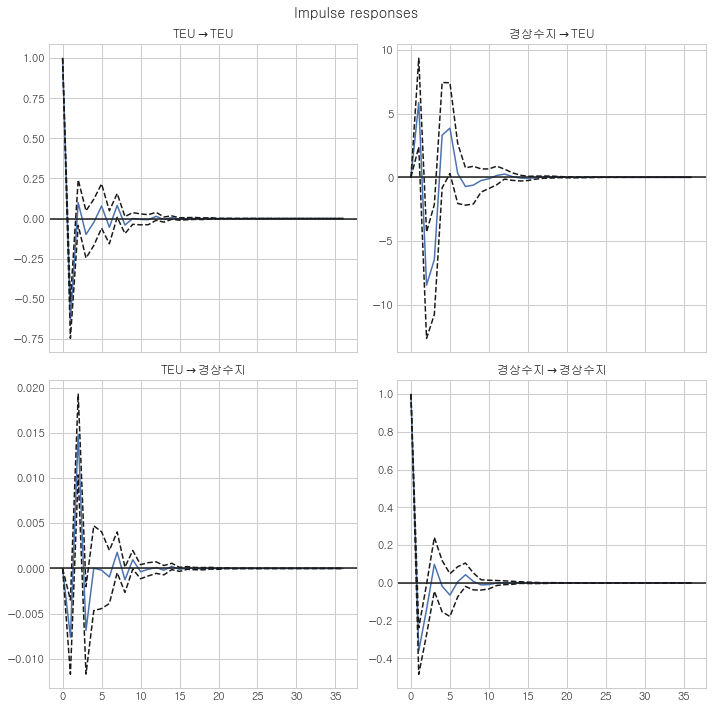

In [52]:
Var_data = data[['TEU','경상수지']]
fit = sm.tsa.VAR(Var_data.diff(1).dropna()).fit(maxlags=4)

forecast_num = 36 
fit.irf(forecast_num).plot()
plt.tight_layout() 
plt.show()

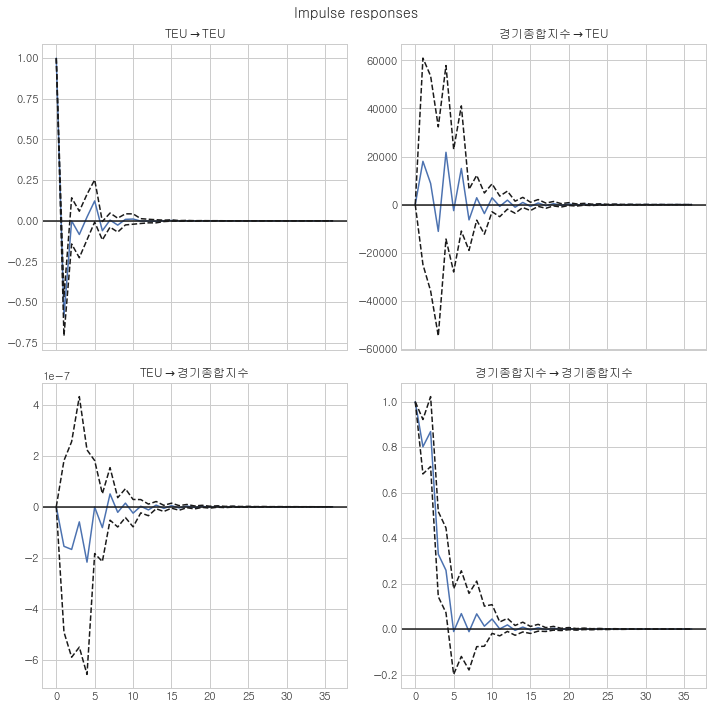

In [53]:
Var_data = data[['TEU','경기종합지수']]
fit = sm.tsa.VAR(Var_data.diff(1).dropna()).fit(maxlags=4)

forecast_num = 36
fit.irf(forecast_num).plot()
plt.tight_layout() 
plt.show()

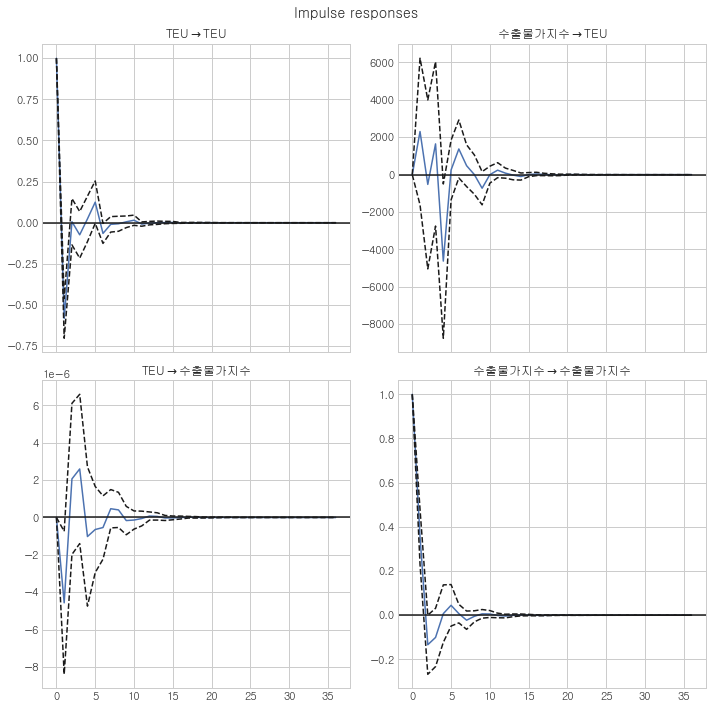

In [54]:
Var_data = data[['TEU','수출물가지수']]
fit = sm.tsa.VAR(Var_data.diff(1).dropna()).fit(maxlags=4)

forecast_num = 36 
fit.irf(forecast_num).plot()
plt.tight_layout() 
plt.show()

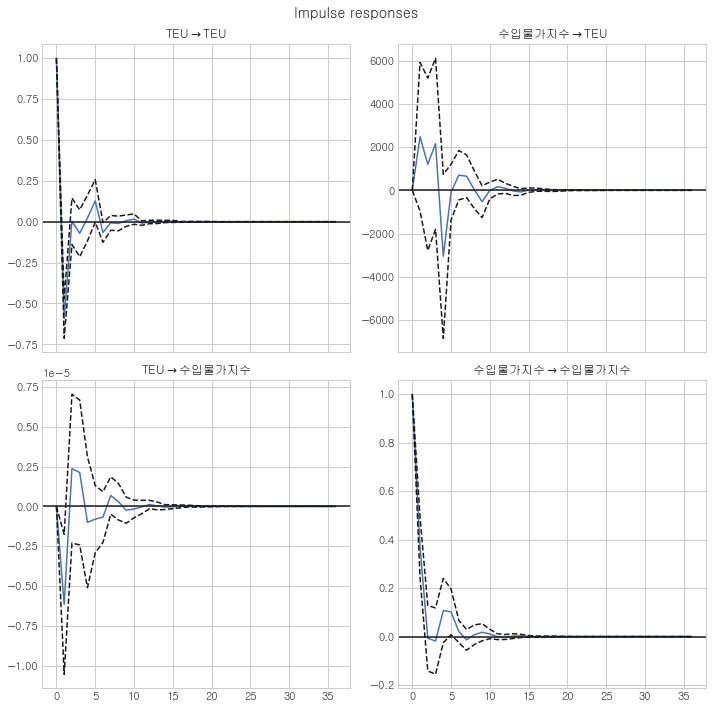

In [55]:
Var_data = data[['TEU','수입물가지수']]
fit = sm.tsa.VAR(Var_data.diff(1).dropna()).fit(maxlags=4)

forecast_num = 36 
fit.irf(forecast_num).plot()
plt.tight_layout() 
plt.show()

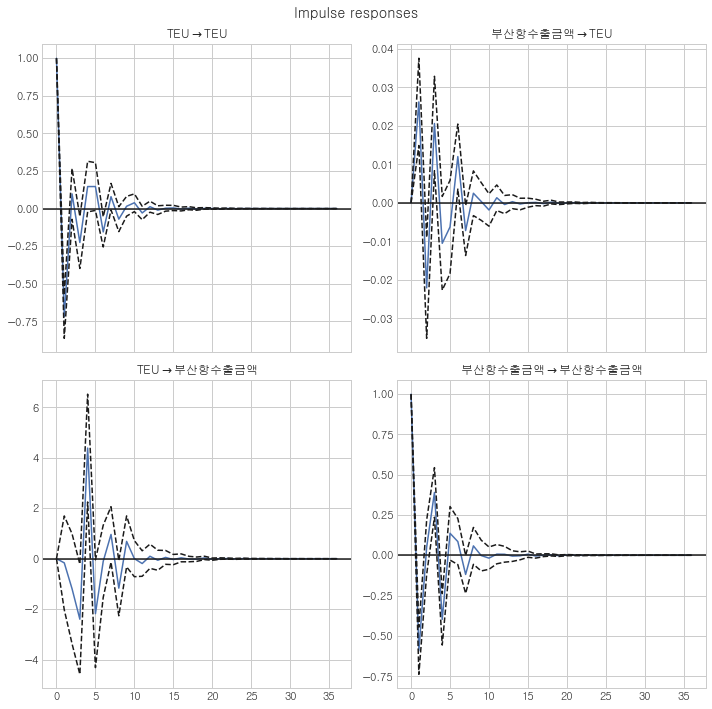

In [56]:
Var_data = data[['TEU','부산항수출금액']]
fit = sm.tsa.VAR(Var_data.diff(1).dropna()).fit(maxlags=4)

forecast_num = 36
fit.irf(forecast_num).plot()
plt.tight_layout() 
plt.show()

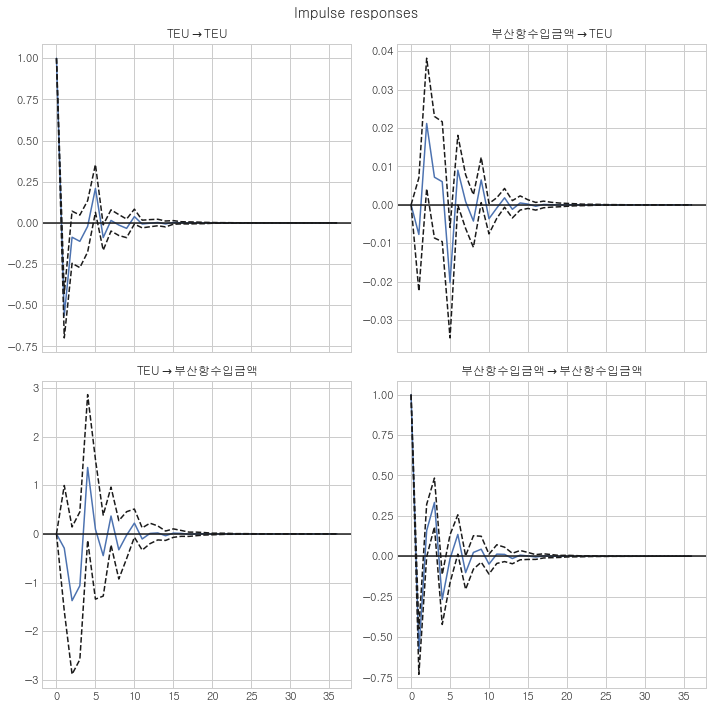

In [57]:
Var_data = data[['TEU','부산항수입금액']]
fit = sm.tsa.VAR(Var_data.diff(1).dropna()).fit(maxlags=4)

forecast_num = 36 
fit.irf(forecast_num).plot()
plt.tight_layout() 
plt.show()